In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download ru_core_news_sm
!pip install tqdm
!pip install sentence-transformers

In [ ]:
from tqdm import tqdm
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import torch
import spacy
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, FunctionTransformer

In [ ]:
user = pd.read_parquet("user.parquet")
friend = pd.read_parquet("friend.parquet")
photo = pd.read_parquet("photo.parquet")
biography = pd.read_parquet("biography.parquet")
post = pd.read_parquet("post.parquet")
group = pd.read_parquet("group_table.parquet")

newd = pd.DataFrame(columns=['user_id', 'anon_pab'])
group2 = group
# Группировка по user_id
for user_id, gr in group2.groupby('user_id'):  # Исправленный цикл
    gr['name'].fillna('', inplace=True)
    counter = gr[gr['name'].str.lower().str.contains('аноним')].shape[0]
    counter += gr[gr['name'].str.lower().str.contains('знакомств')].shape[0]
    new_row = pd.DataFrame({'user_id': [user_id], 'anon_pab': [counter]})
    newd = pd.concat([newd, new_row])
anon_group = newd
anon_group

biography2 = biography.drop(columns=["id", "user_id"]).applymap(lambda x: 0 if (x is None) else 1)
biography2["user_id"] = biography["user_id"]
biography2

friend["city"] = friend["city"].apply(lambda x: None if (x is None or x == "") else x)
friend = friend[friend["city"].notna()]
friend

diff_city_count = friend.groupby('user_id').agg(diff_city_count=("city", "nunique"))
diff_city_count

friends_count = friend.groupby('user_id').agg(friend_count=("id", "count"))
friends_count

avg_photo_likes = photo.groupby('user_id').agg(avg_photo_likes=("like_count", "mean"))
avg_photo_likes

photo_count = photo.groupby('user_id').agg(photo_count=("id", "count"))
photo_count

post_count_owner = post[post["isowner"] == 1].groupby('user_id').agg(post_count_owner=("id", "count"))
post_count_owner

post_count_friend = post[post["isowner"] == 0].groupby('user_id').agg(post_count_friend=("id", "count"))
post_count_friend

post_count_delete = post[post["text"] == "Запись удалена"].groupby('user_id').agg(post_count_delete=("id", "count"))
post_count_delete

group_count = group.groupby('user_id').agg(group_count=("id", "count"))
group_count

user_new = user
user_new["user_id"] = user["id"]
user_new = user_new.drop("id", axis=1)
#user_new = user_new.merge(biography2, left_on="user_id", right_on="user_id", how="left")
user_new = user_new.merge(avg_photo_likes, left_on="user_id", right_on="user_id", how="left")
user_new = user_new.merge(photo_count, left_on="user_id", right_on="user_id", how="left")
user_new = user_new.merge(post_count_owner, left_on="user_id", right_on="user_id", how="left")
user_new = user_new.merge(post_count_friend, left_on="user_id", right_on="user_id", how="left")
user_new = user_new.merge(post_count_delete, left_on="user_id", right_on="user_id", how="left")
user_new = user_new.merge(group_count, left_on="user_id", right_on="user_id", how="left")
user_new = user_new.merge(anon_group, left_on="user_id", right_on="user_id", how="left")
user_new = user_new.merge(diff_city_count, left_on="user_id", right_on="user_id", how="left")
user_new = user_new.merge(friends_count, left_on="user_id", right_on="user_id", how="left")

user_new["like_friend_ratio"] = (user_new["friend_count"]) / (user_new["avg_photo_likes"] + 1)
user_new

user_new["friend_count"] = user_new["friend_count"].fillna(-1)
user_new

user_new.to_parquet("user_new_updated.parquet")

In [58]:
user_new = pd.read_parquet("user_new_updated.parquet")

In [ ]:
# Агрегация названий групп
group_names = group.groupby('user_id')['name'].apply(lambda names: '; '.join(names.dropna().str.strip())).reset_index()
group_names.rename(columns={'name': 'groups_names'}, inplace=True)

# Агрегация описаний групп
group_descriptions = group.groupby('user_id')['description'].apply(lambda descs: '; '.join(descs.dropna().str.strip())).reset_index()
group_descriptions.rename(columns={'description': 'groups_descriptions'}, inplace=True)

# Объединение агрегаций в одну таблицу
groups_aggregated = pd.merge(group_names, group_descriptions, on='user_id', how='outer')


# Объединение с user_new
user_new = user_new.merge(groups_aggregated, left_on="user_id", right_on="user_id", how='left')


In [65]:

candidate_labels = [
    "Sports",
    "Music",
    "Art",
    "Technology",
    "Travel",
    "Education",
    "Health",
    "Erotics",
    "Hobbies",
    "Business",
    "Politics",
    "Violence",
    "Crime",
    "Extremism",
    "Entertainment",
    "Environment"
]
# candidate_labels = [f"Group about {el}" for el in candidate_labels]

In [66]:
model = SentenceTransformer('sergeyzh/rubert-tiny-turbo', device=0)

In [67]:
encoded_labels = model.encode(candidate_labels, convert_to_tensor=True)

# Функция для вычисления разнообразия
def calculate_diversity(embeddings):
    if len(embeddings) <= 1:
        return 0.0
    # Вычисляем матрицу косинусных расстояний
    cosine_sim = util.cos_sim(embeddings, embeddings)
    # Избавляемся от диагонали (расстояние самого себя)
    mask = ~torch.eye(len(embeddings), dtype=torch.bool).to(device=0)
    cosine_sim = cosine_sim.masked_select(mask).reshape(len(embeddings), -1)
    # Усредняем расстояния
    diversity = cosine_sim.mean().item()
    return diversity


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [68]:
import spacy
import re

# Загрузка языковых моделей
try:
    nlp_en = spacy.load('en_core_web_sm')
except OSError:
    print("Модель en_core_web_sm не найдена. Установите её с помощью команды:")
    print("python -m spacy download en_core_web_sm")
    raise

try:
    nlp_ru = spacy.load('ru_core_news_sm')
except OSError:
    print("Модель ru_core_news_sm не найдена. Установите её с помощью команды:")
    print("python -m spacy download ru_core_news_sm")
    raise

def clean_and_lemmatize(text, lang='ru'):
    """
    Очищает и лемматизирует текст.
    
    :param text: Исходный текст.
    :param lang: Язык текста ('en' для английского, 'ru' для русского).
    :return: Лемматизированный текст.
    """
    # Удаление специальных символов и приведение к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    
    # Выбор модели в зависимости от языка
    if lang == 'en':
        doc = nlp_en(text)
    elif lang == 'ru':
        doc = nlp_ru(text)
    else:
        raise ValueError("Поддерживаемые языки: 'en' для английского и 'ru' для русского.")
    
    # Лемматизация и удаление стоп-слов
    lemmas = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    return ' '.join(lemmas)

In [ ]:
import torch
i = 0
for idx, row in tqdm(user_new.iterrows(), total=user_new.shape[0]):
    i += 1
    user_id = row['user_id']
    if type(row['groups_names']) != str:
        continue
    groups = row['groups_names'].split('; ')[:5]  # Берём первые 5 групп
    if not groups:
        user_new.at[idx, "embed_results"] = {
            "categories": [],
            "diversity": 0.0
        }
        continue

    # Очистка и лемматизация названий групп
    processed_groups = [clean_and_lemmatize(f"Группа под названием {group}") for group in groups]
    
    # Кодирование групп
    group_embeddings = model.encode(processed_groups, convert_to_tensor=True)

    # Для хранения топ-3 категорий для каждой группы
    top_categories = []

    for group_embedding in group_embeddings:
        # Вычисляем косинусное сходство с категориями
        cosine_scores = util.cos_sim(group_embedding, encoded_labels)[0]
        # Находим топ-3 индекса категорий с наибольшим сходством
        top_indices = torch.topk(cosine_scores, k=3).indices
        # Получаем названия категорий
        top_cat = [candidate_labels[idx] for idx in top_indices]
        top_categories.append(top_cat)
    
    # Усреднение эмбеддингов групп
    avg_group_embedding = torch.mean(group_embeddings, dim=0)

    # Max Pooling по всем эмбеддингам групп
    max_pooled_embedding, _ = torch.max(group_embeddings, dim=0)

    # Вычисление разнообразия
    diversity = calculate_diversity(group_embeddings) if len(group_embeddings) > 1 else 0.0

    # Сохранение результатов
    user_new.at[idx, "embed_results"] = {
        "categories": top_categories,
        "diversity": diversity,
        "avg_embedding": avg_group_embedding.cpu().numpy().tolist(),
        "max_pooled_embedding": max_pooled_embedding.cpu().numpy().tolist()
    }
    if i%400 == 0:
        user_new.to_parquet('user_temp_results.parquet', index=False)

# Пример сохранения результатов
user_new.to_parquet('user_results.parquet', index=False)

In [42]:
# user_new = pd.read_parquet("/kaggle/input/results/user_results.parquet")

In [ ]:
# Определение IQR
Q1 = user_new['friend_count'].quantile(0.25)
Q3 = user_new['friend_count'].quantile(0.85)
IQR = Q3 - Q1

# Верхняя граница по IQR
upper_bound_IQR = Q3 + 1.5 * IQR

print(f"Upper bound by IQR: {upper_bound_IQR}")

# Фильтрация данных
filtered_IQR = user_new[user_new['friend_count'] <= upper_bound_IQR]

print(f"Number of rows after IQR filtering: {len(filtered_IQR)}")
filtered_IQR["friend_count"] = filtered_IQR["friend_count"].apply(lambda x: None if x==-1 else x)
photodata = pd.read_parquet("/kaggle/input/photodata/ph_c_dataset.parquet")
average_distance_df = photodata.groupby('user_id')['average_distance'].first().reset_index()

# Способ 2: Используя drop_duplicates и сохраняя первую запись
# average_distance_df = photodata[['user_id', 'average_distance']].drop_duplicates(subset='user_id')

# Шаг 2: Объединение user_new с агрегированным DataFrame по user_id
user_new = user_new.merge(average_distance_df, on='user_id', how='left')

# Теперь в user_new появилась колонка 'average_distance' с соответствующими значениями из photodata

# (Опционально) Шаг 3: Проверка на наличие пропущенных значений после объединения
missing_values = user_new['average_distance'].isnull().sum()
if missing_values > 0:
    print(f"Внимание: {missing_values} записей не имеют значения 'average_distance'.")
    # Здесь можно решить, как обработать пропущенные значения, например, заполнить средним значением
    # user_new['average_distance'].fillna(user_new['average_distance'].mean(), inplace=True)
user_new = user_new[~user_new['average_distance'].isna()]
user_new["friend_count"] = user_new["friend_count"].apply(lambda x: None if x==-1 else x)

In [ ]:
import numpy as np

# Среднее и стандартное отклонение для правила 3-х сигм
mean_friend_count = user_new[user_new["friend_count"].isna()]['avg_photo_likes'].mean()
std_friend_count = user_new[user_new["friend_count"].isna()]['avg_photo_likes'].std()

# Среднее и стандартное отклонение для правила 3-х сигм 2
mean_friend_count2 = user_new[~user_new["friend_count"].isna()]['like_friend_ratio'].mean()
std_friend_count2 = user_new[~user_new["friend_count"].isna()]['like_friend_ratio'].std()

# Верхняя граница по правилу 3-х сигм
upper_bound_3sigma = mean_friend_count + 3 * std_friend_count

# Верхняя граница по правилу 3-х сигм 2
upper_bound_3sigma2 = mean_friend_count2 + 3 * std_friend_count2


print(f"Upper bound by 3-sigma rule: {upper_bound_3sigma}")
print(f"Upper bound by 3-sigma rule2: {upper_bound_3sigma2}")

# Фильтрация данных
filtered_3sigma_with_nan = user_new[user_new["friend_count"].isna()].reset_index()
filtered_3sigma_without_nan = user_new[~user_new["friend_count"].isna()].reset_index()

filtered_3sigma_with_nan = filtered_3sigma_with_nan[filtered_3sigma_with_nan['avg_photo_likes'] <= upper_bound_3sigma].reset_index()
filtered_3sigma_without_nan = filtered_3sigma_without_nan[filtered_3sigma_without_nan['like_friend_ratio'] <= upper_bound_3sigma2].reset_index()


# Объединение результатов
all_filtered_3sigma = pd.concat([filtered_3sigma_with_nan, filtered_3sigma_without_nan])

print(f"Number of rows after 3-sigma filtering: {len(all_filtered_3sigma)}")

In [46]:
user_new = all_filtered_3sigma
user_new.drop(columns=["level_0","index"], inplace=True)
user_new.head(1)

In [47]:
user_new["avg_photo_likes"] = user_new["avg_photo_likes"].fillna(0)
user_new["photo_count"] = user_new["photo_count"].fillna(0)
user_new["post_count_owner"] = user_new["post_count_owner"].fillna(0)
user_new["post_count_friend"] = user_new["post_count_friend"].fillna(0)
user_new["post_count_delete"] = user_new["post_count_delete"].fillna(0)
user_new["friend_count"] = user_new["friend_count"].fillna(-30)

user_new.fillna(-0.001, inplace=True)
user_new.drop("like_friend_ratio", axis=1, inplace=True)
user_new

Внимание: 10888 записей не имеют значения 'average_distance'.


In [54]:
user_new = user_new[~user_new["embed_results"].isna()]
user_new = user_new[user_new["embed_results"]!=-0.001]

In [57]:
features = user_new.drop(columns=["first_name", "last_name", "birth_date", "age", "user_id", "avg_photo_likes", "photo_count", "post_count_owner", "post_count_friend", "post_count_delete", "group_count", "anon_pab", "diff_city_count", "friend_count", "groups_names", "groups_descriptions"])

In [84]:
df_expanded = pd.concat([features.drop(['embed_results'], axis=1),
                         features['embed_results'].apply(pd.Series)], axis=1)
# Шаг 2: Развертывание списка категорий
df_expanded['categories'] = df_expanded['categories'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else [])

# Шаг 3: Развертывание 'avg_embedding' на отдельные столбцы
embedding_df = df_expanded['avg_embedding'].apply(pd.Series)
embedding_df.columns = [f'avg_embedding_{i}' for i in embedding_df.columns]
df_expanded = pd.concat([df_expanded.drop(['avg_embedding'], axis=1), embedding_df], axis=1)

# Если нужно использовать 'max_pooling_embedding', аналогично:
# max_pooling_embedding_df = df_expanded['max_pooling_embedding'].apply(pd.Series)
# max_pooling_embedding_df.columns = [f'max_pooling_embedding_{i}' for i in max_pooling_embedding_df.columns]
# df_expanded = pd.concat([df_expanded.drop(['max_pooling_embedding'], axis=1), max_pooling_embedding_df], axis=1)
df_expanded = df_expanded[df_expanded["diversity"]>0.1]
# Теперь DataFrame готов для дальнейшей обработки
print("Развернутый DataFrame:")
print(df_expanded.head())


Развернутый DataFrame:
       vk_id  average_distance categories  diversity  \
1  133343174          0.952222         []   0.855860   
3  476302530          0.911009         []   0.846211   
4  261985066          0.931702         []   0.806725   
5  499246599          0.940610         []   0.853026   
6  332389372          0.957326         []   0.860711   

                                max_pooled_embedding  avg_embedding_0  \
1  [0.013045457191765308, 0.013555492274463177, 0...        -0.002316   
3  [0.013649879954755306, 0.007465928327292204, 0...        -0.011896   
4  [0.020681021735072136, 0.02414199523627758, 0....        -0.014801   
5  [0.001315017230808735, 0.03931649774312973, 0....        -0.025769   
6  [0.04937848821282387, 0.03758891299366951, 0.0...         0.006077   

   avg_embedding_1  avg_embedding_2  avg_embedding_3  avg_embedding_4  ...  \
1        -0.009746         0.041758         0.004280        -0.001239  ...   
3        -0.008784         0.026823        -0

In [86]:
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
        
    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self
    
    def transform(self, X):
        return self.mlb.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_
# Шаг 4: Создание пользовательского трансформера для извлечения эмбеддингов
class EmbeddingExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns].values

# Определяем имена столбцов эмбеддингов
embedding_columns = [col for col in df_expanded.columns if col.startswith('avg_embedding_')]

# Определяем колонку для категорий и остальные числовые признаки
categorical_features = ['categories']
numerical_features = ['diversity', "average_distance"]

# Создаем колонный трансформер для предварительной обработки
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', MultiLabelBinarizerTransformer(), 'categories'),
        ('num', Pipeline([
            ('log1p', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('embed', Pipeline([
            ('extract', 'passthrough'),  # Убедимся, что эмбеддинги проходят через пайплайн
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=3))  # Первый PCA для эмбеддингов
        ]), embedding_columns)
    ],
    remainder='drop'  # Удаляем другие столбцы
)

# Создаем полный пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),  # Второй PCA для всех признаков вместе
    ('cluster', KMeans(n_clusters=2, random_state=42))
])

# Подготовка данных
X = df_expanded # .drop(['average_distance'], axis=1)  # Предполагаем, что 'average_distance' не используется

# Обучение пайплайна
pipeline.fit(X)

# Предсказание кластеров
clusters = pipeline.predict(X)

# Добавляем кластеры в DataFrame
df_expanded['cluster'] = clusters

print("\nDataFrame с кластеризацией:")
print(df_expanded.head())

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



DataFrame с кластеризацией:
       vk_id  average_distance categories  diversity  \
1  133343174          0.952222         []   0.855860   
3  476302530          0.911009         []   0.846211   
4  261985066          0.931702         []   0.806725   
5  499246599          0.940610         []   0.853026   
6  332389372          0.957326         []   0.860711   

                                max_pooled_embedding  avg_embedding_0  \
1  [0.013045457191765308, 0.013555492274463177, 0...        -0.002316   
3  [0.013649879954755306, 0.007465928327292204, 0...        -0.011896   
4  [0.020681021735072136, 0.02414199523627758, 0....        -0.014801   
5  [0.001315017230808735, 0.03931649774312973, 0....        -0.025769   
6  [0.04937848821282387, 0.03758891299366951, 0.0...         0.006077   

   avg_embedding_1  avg_embedding_2  avg_embedding_3  avg_embedding_4  ...  \
1        -0.009746         0.041758         0.004280        -0.001239  ...   
3        -0.008784         0.026823    

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


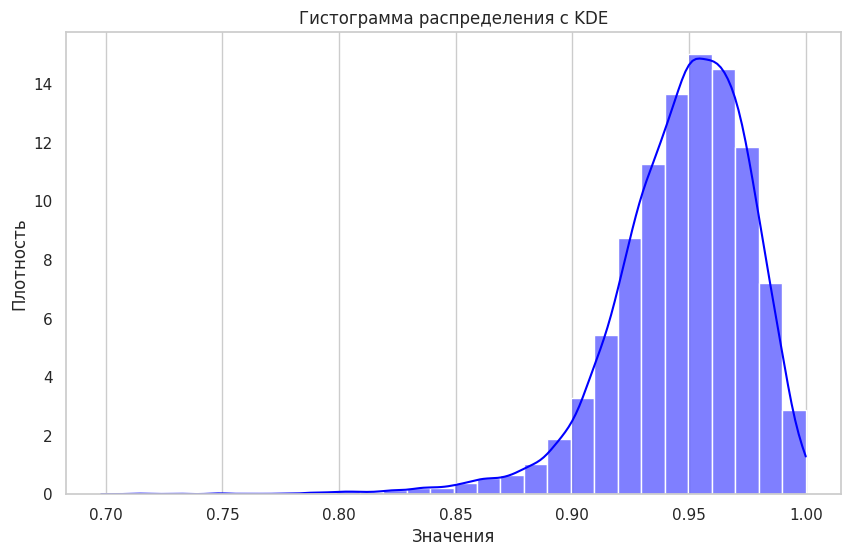

In [87]:
# plt.figure(figsize=(10, 6))
# sns.histplot(df_expanded['average_distance'], bins=30, kde=True, stat='density', color='blue', alpha=0.5)
# plt.title('Гистограмма распределения с KDE')
# plt.xlabel('Значения')
# plt.ylabel('Плотность')
# plt.grid(axis='y')  # Ограничиваем ось X от 0 до 1
# plt.show()

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [88]:
X_preprocessed = pipeline.named_steps['preprocessor'].transform(X)

# Применим PCA для визуализации
pca_vis = PCA(n_components=2, random_state=42)
X_pca_vis = pca_vis.fit_transform(X_preprocessed)

In [89]:
df_vis = pd.DataFrame({
    'PCA1': X_pca_vis[:, 0],
    'PCA2': X_pca_vis[:, 1],
    'Cluster': df_expanded['cluster']
})

print(df_vis.head())

       PCA1      PCA2  Cluster
1  0.577958 -0.830998        1
3  1.330838  0.381444        1
4 -0.118224  0.838446        0
5  0.785345 -0.488903        1
6  0.572765 -1.066339        1


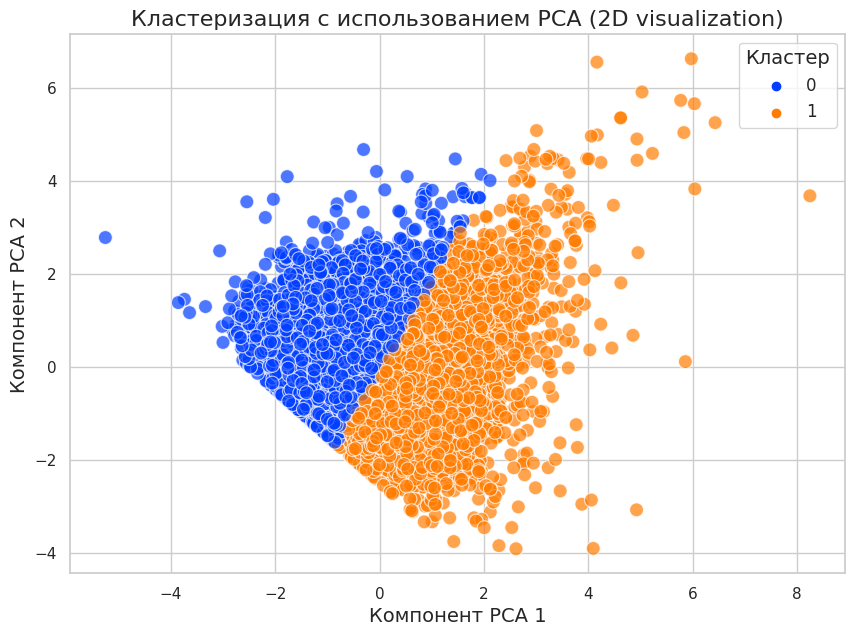

In [90]:
# Настройка стиля графиков
sns.set(style="whitegrid")

# Создаем фигуру и оси
plt.figure(figsize=(10, 7))

# Создаем scatter plot с цветом по кластерам
palette = sns.color_palette("bright", np.unique(df_vis['Cluster']).shape[0])

sns.scatterplot(
    data=df_vis,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette=palette,
    alpha=0.7,
    s=100
)

# Добавляем заголовок и подписи осей
plt.title('Кластеризация с использованием PCA (2D visualization)', fontsize=16)
plt.xlabel('Компонент PCA 1', fontsize=14)
plt.ylabel('Компонент PCA 2', fontsize=14)

# Добавляем легенду
plt.legend(title='Кластер', fontsize=12, title_fontsize=14)

# Отображаем график
plt.show()

In [ ]:
# result.drop(columns=['embed_results']).to_parquet("target3.parquet")

In [91]:
# result = user_new.merge(df_expanded[['vk_id', 'cluster']], on='vk_id', how='left')

# # Замените NaN в столбце 'cluster' на 0
# result['cluster'] = result['cluster'].fillna(0)